<a href="https://colab.research.google.com/github/ashinkrishnan/Volumetric-Medical-Image-Segmentation-using-2D-U-NET/blob/main/u_net_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !nvidia-smi

In [ ]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

In [ ]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
    
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras
import nibabel as nib

In [ ]:
# Define constants
SEED = 909
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_TEST  = 128

IMAGE_HEIGHT = 256
IMAGE_WIDTH  = 192
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = '/content/drive/MyDrive/data/slices'
data_dir_train = os.path.join(data_dir, 'training')
# The images stored under: "data/slices/training/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'img')
# The images stored under: "data/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'mask')

data_dir_test = os.path.join(data_dir, 'test')
# The images stored under: "data/slices/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'img')
# The images stored under: "data/slices/test/mask/img"
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

NUM_TRAIN = 2560 
NUM_TEST  = 1024

NUM_OF_EPOCHS = 10

In [ ]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return (pair for pair in zip(img_generator, msk_generator))
    #return zip(img_generator, msk_generator)

In [ ]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)

Found 2560 images belonging to 1 classes.
Found 2560 images belonging to 1 classes.


In [ ]:
# Remember not to perform any image augmentation in the test generator!
def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return (pair for pair in zip(img_generator, msk_generator))
    #return zip(img_generator, msk_generator)

In [ ]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 1024 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.


In [ ]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [ ]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        print(image[0].shape,mask[0].shape)
        display([image[0], mask[0]])

(256, 192, 1) (256, 192, 1)


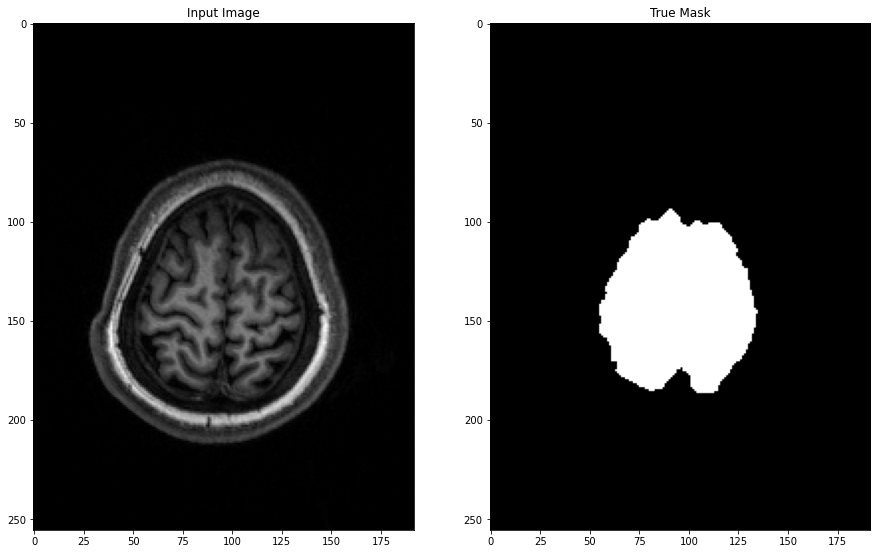

In [ ]:
show_dataset(train_generator, 1)

In [ ]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [ ]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

model = unet(2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "UNET-L2-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 192, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 192, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 192, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 96, 32)  0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [ ]:
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=NUM_OF_EPOCHS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
20/20 [==============================] - 1926s 97s/step - loss: 0.4895 - accuracy: 0.8740 - val_loss: 0.2119 - val_accuracy: 0.9027
Epoch 2/10
20/20 [==============================] - 1471s 74s/step - loss: 0.1687 - accuracy: 0.9024 - val_loss: 0.1576 - val_accuracy: 0.9015
Epoch 3/10
20/20 [==============================] - 1475s 74s/step - loss: 0.1330 - accuracy: 0.9030 - val_loss: 0.1328 - val_accuracy: 0.9027
Epoch 4/10
20/20 [==============================] - 1477s 74s/step - loss: 0.1203 - accuracy: 0.9024 - val_loss: 0.1258 - val_accuracy: 0.9064
Epoch 5/10
20/20 [==============================] - 1479s 74s/step - loss: 0.1154 - accuracy: 0.9032 - val_loss: 0.1196 - val_accuracy: 0.9033
Epoch 6/10
20/20 [==============================] - 1479s 74s/step - loss: 0.1110 - accuracy: 0.9039 - val_loss: 0.1200 - val_accuracy: 0.9010
Epoch 7/10
20/20 [==============================] - 1487s 75s/step - loss: 0.1191 - accuracy: 0.9419 - val_loss: 0.1176 - val_accuracy: 0.9556

In [ ]:
model.save('/content/drive/MyDrive/UNET-MRI-brain.h5')

In [ ]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1)

Found 1024 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.


In [ ]:
def show_pred(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0]>0.181
        #print(image[0].shape,mask[0].shape)
        display([image[0], mask[0],pred_mask])

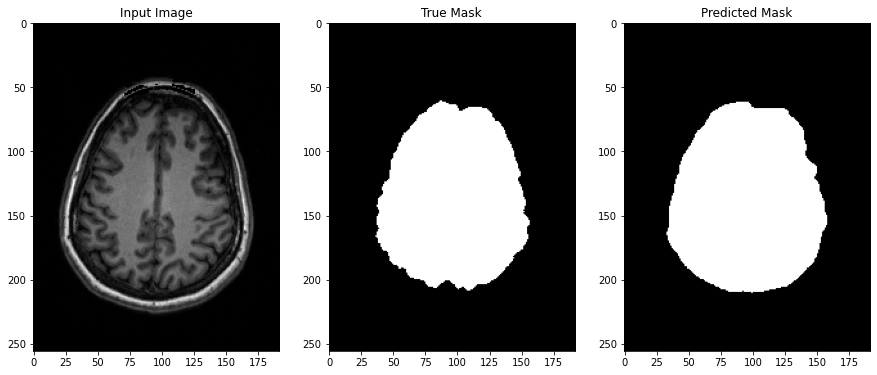

In [ ]:
show_pred(test_generator,1)